# INF581 - Lab 01

### Main Objectives of the Lab 

Intelligent decision making involves several components. Today we will study, in the context of a toy (low-dimensional, synthetic) example: *perception* (observation), *knowledge* (representation), *reasoning* (inference), and *acting* (decision-making). We will _not_ look at (today) at learning and sequential decision making. Using probabalistic tools covered in the lecture (Bayesian networks, marginalization, ...), the objective is to design a rational/intelligent agent, i.e., an agent that maximizes expected reward. 


### Instructions

Work your way through the notebook, and provide code to complete the tasks. You can add as much code (and as many code blocks) as you want to solve the task, but make sure it is in a block containing an `## EXTRACT` tag, and don't change the names of existing functions or their parameters. Do not remove or add any of the `## EXTRACT` markers. Check Moodle for details on how to submit work. 

## Task 0: Name your work

Replace the values in the following dictionary `info`. Your Email must match your class email address. Your Alias will be shown on the public leaderboard (to identify yourself). 

In [1]:
## EXTRACT
    
info = {
        'Email' : 'yannis.kedadry@polytechnique.edu',
        'Alias' : 'yKedadry', # (change this in case you want to identify yourself on the leaderboard)
}

### Imports

First, we're going to import `numpy` and some utility functions/classes that we will use throughout. You can come back later and add your own code if you want. 

In [2]:
## EXTRACT 

import numpy as np

def tile2cell(y, n_col):
    ''' utility function: convert tile number to matrix row, col'''
    return int(y - 1) // n_col, int(y - 1) % n_col

def cell2tile(row, col, n_col):
    return col + row * n_col

class PMF:

    ''' Probability Mass Function representation and associated functions'''
    
    d = {} 

    def __init__(self,d = {}):
        ''' use dictionary d to represent a pmf (and check that it is normalized) '''
        Z = np.sum(np.array(list(d.values())))

        if Z != 0 and Z != 1:
            # normalize
            d = {key: value / Z for key, value in d.items()}

        self.d = d

    def prob(self, x):
        ''' evaluates p(x) where x a numpy array '''
        x_str = ' '.join(map(str,x))
        if x_str not in self.d.keys(): 
            return 0
        return self.d[x_str] 

    def sample(self):
        ''' samples x ~ p(x) where x a numpy array '''
        x_str = np.random.choice(list(self.d.keys()), p=np.array(list(self.d.values())))
        return np.fromstring(x_str.strip('[]').encode(), sep=' ', dtype=int)

def getState(env, i, j):
    return env.states[cell2tile(i, j, env.n_cols)]

def getEntryPoints(env):
    res = []
    for i in range(len(env.G)):
        for j in range(len(env.G[0])):
            if env.G[i,j] >= 4:
                res.append(getState(env, i,j))
    return res

def getSurroundingCells(env, state):
    row, col = tile2cell(state, env.n_cols)
    surrounding_states = []
    for i in range(max(0, row - 1), min(env.n_rows, row + 2)):
        for j in range(max(0, col - 1), min(env.n_cols, col + 2)):
            surrounding_states.append(getState(env, i,j))
    return surrounding_states

def doesCellCorrespond(env, crinkle, rustle, state):
    row, col = tile2cell(state, env.n_cols)
    cellValue = env.G[row,col]
    # crinkle
    if(crinkle == 1):
        if(cellValue != 1 and cellValue != 3):
            return False
    # rustle
    if(rustle == 1):
        if(cellValue != 2 and cellValue != 3):
            return False
            
    return True

In [3]:
# Only for plotting
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

## The Agent

Consider an intelligent robot tasked with catching rats in a storage room. It is night time, and the room is dark. You have to rely on auditory information only, but luckily the room is a mess with paper and other debris that means there are distinct sounds which are emitted by a rat as it touches different objects (namely, crinkling and rustling sounds). The room is rectangular, divided up into $n$ square tiles.  A rat has just entered the room (time $t=1$). The agent waits T seconds (until $t=T$), then makes a decision on if and where to pounce (in order to catch the rat).  

Let's denote: $y_t \in \{1,\ldots,n\}$ the position (state) of the rat at time step $t$ (one of $n$ grid tiles); starting at some $y_1$ (entry tile). And $\mathbf{x}_t \in \{0,1\}^2$ is the 2-dimensional auditory observation at time $t$ (e.g., $\mathbf{x}_t = [1,0]$ if there is a crinkle but no rustle, etc). The agent accumulates a sequence of $\mathbf{x}_{1:T} = \mathbf{x}_1,\ldots,\mathbf{x}_T$, which can be considered its input **observation**, with which to make the decision of taking **action** $a$ to pounce (denoting the tile upon which it pounces), or $a=0$ to not pounce. The agent obtains **reward** $r(s,a)$ (this function is already implemented in the environment), obviously catching the rat by pouncing to the correct tile ($s=a$) is better than missing it ($s\neq a$).

Your task is to model this problem, and provide the best action $a$ (according to current knowledge -- a given sequence $\mathbf{x}_{1:T}$) and associated uncertainty.

Be aware of the potential confusion here: $s = y_T$ represents the state of the environment at time $y_T$ and decision making (choosing action $a$) is based on observation $o = \mathbf{x}_{1:T}$. Since the decision, being made at time $T$, does not affect the future observations, this is a Markov process + a decision rather than a Markov decision process. 

## The Environment

You have full *knowledge* of the environment. Indeed, the Environment is fully specified for you, as a Markov process 
$$
    y_{t+1} \sim p(\cdot | y_t)
$$
with observation process $\mathbf{x}_t \sim p( \cdot | y_t)$. A `step` function is implemented to produce the observations.  

Simply run the following code block then come back here to read the explanation for what you see. 

You can inspect the code to see that `P_Y_y` implements $p(\cdot | y_t)$ such that the target moves by exactly $1$ square tile, either horizontally or vertically (i.e., taxicab-distance) per time step $t$, within the bounds of the of the room, starting at one of the entry points (uniformly at random) as specified by `P_Y`. Insofar as the observation function `P_X_y`: an audible 'crinkle' with probability $\theta_1$ when over certain tiles (green, or orange) is emitted, and with probability $0$ over other tiles; furthermore, it will invoke a 'rustling' noise with probability $\theta_2$ over certain tiles (red, or orange), and $0$ otherwise. On orange tiles, both noises are caused independently of each other. 

In [4]:
## EXTRACT ENVIRONMENT 

class Environment():
 
    def __init__(self, G, theta = [0.9,0.8]):
        ''' 
            Environment.
            
            Parameters
            ----------
            
            G : array_like(int, ndim=2) of shape (n_rows,n_columns) 
                Specifies a grid where G[j,k] = entry & sound1 & sound2
        
            theta : array_like(float, ndim=1) 
                Specifies the grid dynamics (acoustics) 
            
        '''
        # Grid
        self.G = G
        
        # Grid shape
        self.n_rows = G.shape[0]
        self.n_cols = G.shape[1]
        self.n_states = self.n_cols * self.n_rows
        
        # State space - tile number representation
        self.states = np.arange(1,self.n_states+1)
        
        # Observation function
        self.theta = theta        
   
    def rwd(self, s, a): 
        '''
            Reward function r(s, a) of taking action a given state s

            Parameters
            ----------
            s : int
                true state (tile which containts the object)
            a : int
                estimated state
                
            Returns
            -------
            float
                reward obtained from taking action a given state s
        '''
        return (s==a) * 10 + (s!=a) * -3
   
    def P_X_y(self,y):
        ''' Observation distribution.

            Parameters
            ----------
            s : int
                current tile/state

            Returns
            -------
                p where p[j] = p(Xj = 1 | y)
        '''
        # Convert to cell-coordinates representation
        i,j = tile2cell(y, self.n_cols)
        d = {}
        if self.G[i,j] == 0 or self.G[i,j] > 3:
            d = {
                '0 0' : 1.0
            }
        elif self.G[i,j] == 1: # 0,1
            d = {
                '0 1' : self.theta[1],
                '0 0' : 1 - self.theta[1],
            }
        elif self.G[i,j] == 2: # 1,0
            d = {
                '1 0' : self.theta[0],
                '0 0' : 1-self.theta[0],
            }
        elif self.G[i,j] == 3:
            d = {
                '0 0' : (1 - self.theta[0]) * (1 - self.theta[1]),
                '0 1' : self.theta[0] * (1-self.theta[0]),
                '1 0' : (1-self.theta[0]) * (1-self.theta[1]),
                '1 1' : self.theta[0] * self.theta[1],
            }
            
        return PMF(d)

    def P_Y(self):
        ''' Distribution P(Y_1).

            Returns
            -------
            array_like (n_cols * n_rows) 
                where P[i,j] = P(Y_1 = y) where y the tile at row i, col j
        '''
        n_entries = np.sum(self.G >= 4)
        return (self.G >= 4) * 1 / n_entries

    def P_Y_y(self,_y):
        ''' Distribution P(Y_t | Y_{t-1}).

            Parameters
            ----------
            _y : int
                previous tile/state

            Returns
            -------
            array_like (n_cols * n_rows)
                where P[i,j] = P(Y_t = y | Y_{t-1} = _y) where y the tile at row i, col j
        '''
        if _y is None:
            return self.P_Y()

        if _y not in self.states:
            raise Exception("Sorry, %d is not one of the states" % _y)

        j,k = tile2cell(_y, self.n_cols)
        
        G = np.zeros_like(self.G)
        if j > 0:
            G[j-1,k] = 1
        else:
            G[j,k] = 1
        if j < (self.n_rows-1):
            G[j+1,k] = 1
        else:
            G[j,k] = 1
        if k > 0:
            G[j,k-1] = 1
        else:
            G[j,k] = 1    
        if k < (self.n_cols-1):
            G[j,k+1] = 1
        else:
            G[j,k] = 1

        return G / np.sum(G)

    def step(self, _y):
        ''' Step to the next state, given current state _y.

            The agent's actions do not affect the environment. 
            
            
            Paramaters
            ----------
            
            _y : int
                current state
                
            Returns   
            -------
            
            y : int 
                next state
            o : int
                corresponding observation
        '''  
        # Generate a state y' ~ p( . | y)
        w = self.P_Y_y(_y).flatten()
        y = np.random.choice(self.n_states,p=w) + 1

        # Generate an observation x' ~ p(. | y')
        pmf = self.P_X_y(y) 
        x = pmf.sample()
        
        return y, x

        
    def gen_path(self, T=5):
        ''' Generate a path with associated observations.


            Paramaters
            ----------
            
            T : int
                how long is the path
            
            Returns   
            -------
            
            x : (T,d)-shape array 
                sequence of observations
            y : T-length array of states
                sequence of tiles
        '''

        x = np.zeros((T,len(self.theta)),dtype=int)
        y = np.zeros(T,dtype=int)

        # (t-1)-th state
        _y = None

        for t in range(T):

            # Generate next step
            y[t], x[t] = self.step(_y)
            
            # And remember this state
            _y = y[t]

        return x, y

    def plot_scenario(self, y_seq=None, x_seq=None, dgrid=None, a_star=None, paths=[], title=None):
        '''
            Plot a visual representation of the environment.
            
            Parameters
            ----------
            
            y_seq : numpy array (dtype=int)
                a path (e.g., [1,3,1,2])
                
            x_seq :
                observations associated with the path
                
            dgrid : shape like self.G
                contains values (e.g., probabilities) to show in each tile
                
            a_star : int
                the optimal action
                
            title : str
                a title for the plot
                
        '''

        fig, ax = plt.subplots(figsize=[8,4])

        # Plot the tiles in the room

        if dgrid is None:
            color_map = ListedColormap(["white", "green", "red", "orange", "yellow"])
            im = ax.imshow(self.G, cmap=color_map, interpolation='none',alpha=0.3)
        else:
            color_map = plt.cm.Reds
            im = ax.imshow(dgrid, cmap=color_map)

        # Plot the path, if there is one, e.g., [1,3,1,2,...]
        # alongside the observations generated by that path, and the optimal action.
        if title is not None:
            ax.set_title(title)
            
        if y_seq is not None:
            
            # Draw the path
            T = len(y_seq)
            y_coords = np.array([tile2cell(y_t,env.n_cols)[0] for y_t in y_seq]) + np.random.randn(T)*0.1
            x_coords = np.array([tile2cell(y_t,env.n_cols)[1] for y_t in y_seq]) + np.random.randn(T)*0.1
            ax.plot(x_coords,y_coords,"ko-")
            ax.plot(x_coords[-1],y_coords[-1],"kx",markersize=20)
            
            # Draw the action (i.e., target tile)
            if a_star is not None:
                y_coord = tile2cell(a_star,env.n_cols)[0]
                x_coord = tile2cell(a_star,env.n_cols)[1]
                ax.plot(x_coord,y_coord,"m+",markersize=15)    

            # Draw the sounds (observations)
            if x_seq is not None:
                colors = [ im.cmap(im.norm(value)) for value in [1,2]]
                indices = x_seq[:, 0] > 0
                ax.scatter(np.array(x_coords)[indices], np.array(y_coords)[indices], marker='o', s=200, facecolors='none', edgecolors=colors[0])
                indices = x_seq[:, 1] > 0
                ax.scatter(np.array(x_coords)[indices], np.array(y_coords)[indices], marker='o', s=250, facecolors='none', edgecolors=colors[1])
                           
        
        for path in paths:
            # Draw the path
            T = len(path)
            y_coords = np.array([tile2cell(s,env.n_cols)[0] for s in path]) + np.random.randn(T)*0.1
            x_coords = np.array([tile2cell(s,env.n_cols)[1] for s in path]) + np.random.randn(T)*0.1
            ax.plot(x_coords,y_coords,"mo:")
            ax.plot(x_coords[-1],y_coords[-1],"mx",markersize=10)
        
        
        # Ticks and grid

        ax.set_xticks(np.arange(0, self.n_cols, 1))
        ax.set_xticks(np.arange(-0.5, self.n_cols, 1), minor=True)
        ax.set_xticklabels(np.arange(0, self.n_cols, 1))

        ax.set_yticks(np.arange(0, self.n_rows, 1))
        ax.set_yticks(np.arange(-0.5, self.n_rows, 1), minor=True)
        ax.set_yticklabels(np.arange(0, self.n_rows, 1))

        ax.grid(which='minor', color='k')

        n = 0
        for i in range(self.n_rows):
            for j in range(self.n_cols):
              ax.text(j, i, self.states[n], va='center', ha='center')
              n = n + 1

        # Legend (for the map)

        if dgrid is None:
            labels = ['Crinkle', 'Rustle', 'Crinkle/rustle', 'Entry point']
            colors = [ im.cmap(im.norm(value)) for value in range(1,len(labels)+1)]
            patches = [ mpatches.Patch(color=colors[i], alpha=0.3, label=labels[i] ) for i in range(len(labels)) ]
            plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0. )

        # Return

        plt.tight_layout()
        return fig, ax

### Instantiating the Environment

Let's instantiate an environment, generate a path, and plot it. It is important to realise that although the agent can have full access to the environment, as well as observations, we do not have access to the true path $y_1,\ldots,y_T$ and hence the challenge in estimating $y_T$.

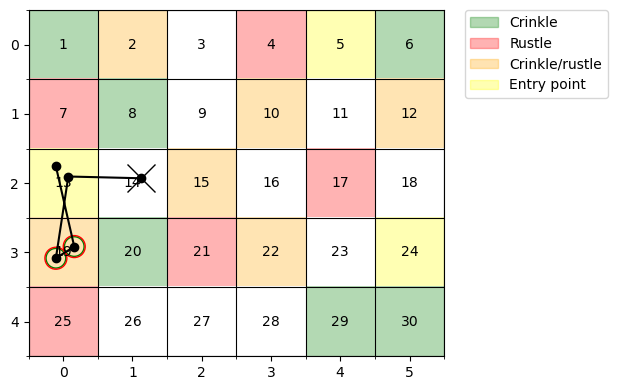

In [5]:
# Design a map
G = np.array([[1,3,0,2,4,1],
              [2,1,0,3,0,3],
              [4,0,3,0,2,0],
              [3,1,2,3,0,4],
              [2,0,0,0,1,1]]);

# Init. the environment 
env = Environment(G)

# Generate a path
xxx, yyy = env.gen_path()
fig, ax = env.plot_scenario(y_seq=yyy, x_seq=xxx)

### Implementing the Agent 

Recall: The Agent is responsible for receiving observation $o = \mathbf{x}_{1:T}$ and producing prediction $a$, i.e., it implements $a = \pi(o)$, i.e., its policy or `action_selection` function as it is called here below. 

The following tasks should be implemented within the following `Agent` class. 

In [6]:
## EXTRACT

class TreeNode:

    def __init__(self, data):
        self.cellId = data
        self.children = []
        self.parent = None

    def getId(self):
        return self.cellId

    def addChild(self, child):
        self.children.append(child)
        child.parent = self

    def pathsDFS(self):
        paths = []
        self._pathsDFSRecursive(self, [], paths)
        return paths

    def _pathsDFSRecursive(self, node, current_path, paths):
        if node is None:
            return
        # Append the current node to the current path
        current_path.append(node.cellId)
        # If it's a leaf node, add the current path to the list of paths
        if not node.children:
            paths.append(current_path[:])
        # Recursively call _pathsDFSRecursive on unvisited children
        for child in node.children:
            self._pathsDFSRecursive(child, current_path, paths)
        # Backtrack: remove the current node from the current path
        current_path.pop()

In [7]:
## EXTRACT AGENT

class Agent():

    def getNextNode(self, curNode, xxx, env):
        if(len(xxx) == 0):
            return
        crinkle = xxx[0][1]
        rustle = xxx[0][0]
        # update xxx
        nextxxx = xxx[1:]
        # for each surrounding cell
        possibleCells = getSurroundingCells(env, curNode.getId())
        for cell in possibleCells:
            # if noise corresponds, add the child to curNode and call recursively
            if(doesCellCorrespond(env, crinkle, rustle, cell)):
                newNode = TreeNode(cell)
                curNode.addChild(newNode)
                self.getNextNode(newNode, nextxxx, env)
            

    def getPossiblePaths(self, xxx, env):
        '''
        return a list of possible paths (int, ndim=2) eg., [[1,2,3,4,5,3],[1,2,3,2,1,4],...]
        '''
        paths = []
        trees = []
        # start from each possible starting points
        for startPoint in getEntryPoints(env):
            # create a tree from it
            curTree = TreeNode(startPoint)
            self.getNextNode(curTree, xxx[1:], env)
            # get all the possible paths from the tree
            pathsTmp = curTree.pathsDFS()
            # if path is of correct size, keep it
            for path in pathsTmp:
                if(len(path) == len(xxx)):
                    paths.append(path)
        
        return paths


    def P_YYY_xxx(self,xxx,env):
        '''
        Full conditional distribution of a path given sequence of observations. 

        $$
            P( Y_1,...,Y_T | x_1,...,x_T )
        $$

        Parameters
        ----------

        xxx : array_like(int,ndim=2)
            T observations (of 2 bits each)

        env : Environment 
            the environment that produced observation x

        Returns
        -------
        dict(str:float)
            d such that d[str(yyy)] is the probability of observing path yyy
            and if str(y) not in d, implies 0 probability
            where yyy is array_like(int, ndim=1), e.g., [5, 4, 7, 13, 12]
        '''

        # create list of possible path
        possiblePaths = self.getPossiblePaths(xxx, env)
        d = {}
        for path in possiblePaths:
            # init the probability P = P(Y0)*P(X0|Y0)
            y0 = path[0]
            x0 = xxx[0]
            i,j = tile2cell(y0, env.n_cols)
            
            py = env.P_Y()[i,j]
            pxy = env.P_X_y(y0).prob(x0)
            p = py * pxy
            # product of conditional probabilities P = P * prod(P(Yt|Yt-1) * P(Xt|Yt))
            for k in range(1, len(xxx)):
                yt = path[k]
                i,j = tile2cell(yt, env.n_cols)
                yt_1 = path[k-1]
                xt = xxx[k]

                pyy = env.P_Y_y(yt_1)[i,j]
                pxy = env.P_X_y(yt).prob(xt)
                p *= pyy * pxy
            # add the probability to d
            path_str = ' '.join(map(str,path))
            d[path_str] = p
        return PMF(d)

    def P_Y_xxx(self,xxx,env,t=-1): 
        '''        
        The (conditional) marginal distribution on state t under observation xxx. 

        $$
            P(Y_t | x_1,...,x_T ).
        $$
        
        The probability (distribution) of the t-th state, given all the observed evidence.


        Parameters
        ----------

        xxx : array_like(int,ndim=2)
            T observations (of 2 bits each)

        t : int
            the given state, e.g., 3, or -1 for final state

        Returns
        -------

        P : array_like(float,ndim=2)
            such that P[i,j] is the probability of being in state y_t at time t
            where i,j = tile2cell(y_t)
        '''

        d_marg = {}

        pmf = self.P_YYY_xxx(xxx,env) # Hint: this can save you some work

        P = np.zeros_like(env.G,dtype=float)

        # calculate the state distribution
        for path_str, prob in pmf.d.items():
            path = list(map(int, path_str.split()))
            yt = path[t]
            i,j = tile2cell(yt, env.n_cols)
            # if the cell was not marked
            if (i,j) not in d_marg:
                d_marg[(i,j)] = 0
            d_marg[(i,j)] += prob

        for (i, j), prob in d_marg.items():
            P[i, j] = prob

        return P 

    def Q_A(self,xxx,env):
        '''
        We want the reward (value) for any given action a.

        $$
            E[ r(S,a) | x_1,...,x_T ] 
        $$

        Since you do not know the exact state, you need to marginalise out your uncertainty. 


        Parameters
        ----------

        xxx : array_like(int,ndim=2)
            T observations (of 2 bits each)

        env : Environment 
            the environment that implements env.rwd(s,a)

        Returns
        -------

        Q : array_like(float,ndims=2)
            such that Q[i,j] where tile2cell(a) is the value (expected reward) of action a.

        '''

        Q = np.zeros_like(env.G,dtype=float)

        P = self.P_Y_xxx(xxx,env) # Hint

        for i in range(len(P)):
            for j in range(len(P[0])):
                pyt = P[i,j]
                S = getState(env, i, j)
                rwdCorrectA = env.rwd(S, S)
                rwdCorrectNotA = 0
                rwdNotCorrectA = env.rwd(S, S+1)
                rwdNotCorrectNotA = 0
                Q[i,j] = (rwdCorrectA + rwdCorrectNotA) * pyt + (rwdNotCorrectA + rwdNotCorrectNotA) * (1-pyt)
        
        return Q

    def action_selection(self,xxx,env):
        '''
        Decide on the best action to take, under observation xxx.

        Parameters
        ----------

        xxx : array_like(int,ndim=2)
            T observations (of 2 bits each)

        env : Environment 
            the environment that implements env.rwd(s,a)

        Returns
        -------

        int,float
            the action a*, and its associated value Q(a*)

        '''

        Q = self.Q_A(xxx,env) # Hint
        a = 1
        max = float('-inf')
        for i in range(len(Q)):
            for j in range(len(Q[0])):
                if Q[i,j] > max:
                    max = Q[i,j]
                    a = getState(env, i,j)
        
        return a



In [8]:
# Init. the agent 
agent = Agent()

## Task 1: Joint distribution (distribution over paths)

What is the distribution over all paths the target could have taken for a given sequence of observations? We are looking for 
$$
    P(Y_{1:T} | \mathbf{x}_{1:T})
$$

**Task**: Edit the `Agent` code where indicated by `TODO`; specifically relating to function `P_YYY_xxx` (but you may add other functions if you need them). Run the following cell to have an idea of what is expected.  

We could expect the path [13 19 19 13 13] with probabilty 0.366410 


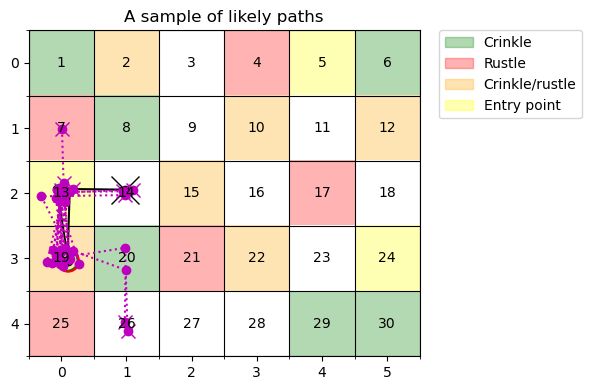

In [9]:
# Task 1. Get joint-conditional distribution
pmf = agent.P_YYY_xxx(xxx,env)
path = pmf.sample()
print("We could expect the path %s with probabilty %8.6f " % (path, pmf.prob(path)))

# Generate some possible paths
paths = [pmf.sample() for i in range(10)]

# ... and plot them
fig, ax = env.plot_scenario(y_seq=yyy, x_seq=xxx, paths=paths, title="A sample of likely paths")

## Task 2: Marginal distribution (over final states)

What is the distribution over all final states the target could be at? We are looking for 
$$
    P(Y_{T} | \vec{x}_{1:T})
$$

**Task**: Edit the `Agent` code where indicated by `TODO`, in particular the `P_Y_xxx` function. Check the plot produced by the next cell to have an idea of what is expected. Recall: we do not have access to the path shown, only observations. 

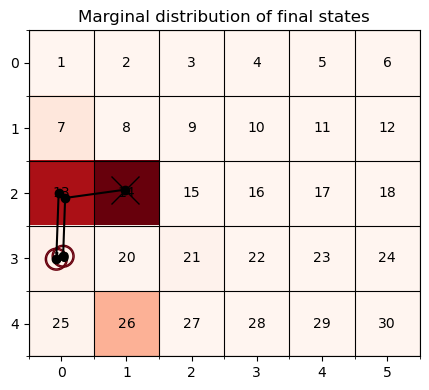

In [10]:
# Task 2. Get marginal distribution
P = agent.P_Y_xxx(xxx,env)
fig, ax = env.plot_scenario(y_seq=yyy, x_seq=xxx, dgrid=P, title="Marginal distribution of final states")

## Task 3: Taking an Action

You've now observed evidence $\mathbf{x}_1,\ldots,\mathbf{x}_T$, and queried the model, according to your beliefs (environment dynamics). Time to make a decision. Which action to take?

$$
    a_* = \text{argmax}_a E_{S \sim P(Y_T | \mathbf{x}_{1:T})}[ r(S, a) ]
$$

Note your uncertainty about the final state $S$. 

In this scenario the action will not affect future observations (because $y_T$ is the final observation), thus you are essentially making an estimate:
$$
    a = \hat y_{T} = \pi(\mathbf{x}_{1:T})
$$

**Task 3a**: You need to evaluate the expectation. As this is essentially 'value', we call it `Q` inline with reinforcement learning terminology. You complete this task in the function `Q_A`. Hint: You already have $p(Y_T | \vec{x}_{1,\ldots,T})$

**Task 3b**: Wrap the argmax around the outside (i.e., make the decision/take the action). This involves the function `action_selection`.

Run the following code block to have a look at the outcome. 

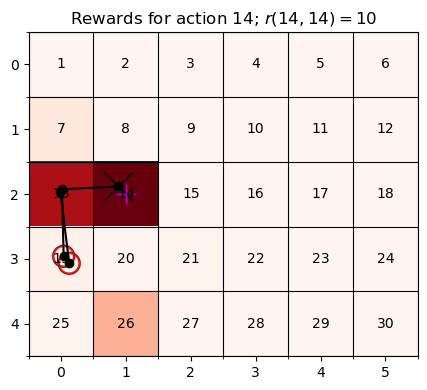

In [11]:
# Task 3. Obtain values
Q = agent.Q_A(xxx,env)

# Decide on an action
a = agent.action_selection(xxx, env)

# Compare to the ground truth
r = env.rwd(yyy[-1],a)

# Plot the result
fig, ax = env.plot_scenario(y_seq=yyy, dgrid=Q, a_star=a, x_seq=xxx, title="Rewards for action %d; $r(%d,%d) = %d$" % (a,yyy[-1],a,r))

## Conclusion (So What?)

Was it the right action? Did you expect to be? Recall what it implies (and what it doesn't imply) to be an optimal agent. 

This was just a toy example, but consider the fundamental concepts here (we will be using them again); and think about real-world examples where such an approach might be relevant. 

It was the right action, but it is not always the case. The choice of taking the action or not actually depends on what we want the agent to be. If we need a risk-prone agent, then always taking the action is probably the best choice (if we really hate mice and don't mind loud noise everytime the agent jumps). On the opposite hand, if we want to have a peaceful sleep we will only take the action when we are a hundred percent sure that the mouse will be in the found state.